# Interactive and Non-blocking Operation

The following sections in this notebook demonstrate methods for interacting with TCLab, for building non-blocking implementations of a control loop, and for various experiments and tests with the package.

## Experiments in Non-blocking Operation with `threading` Library

The current implementation of 

In [1]:
def bar():
    clock.send(None)

def clock(tperiod):
    tstart = time.time()
    tfinish = tstart + tperiod
    t = 0
    while t + tstart < tfinish:
        z = yield t
        t += 1

def bar():
    clock.send(2)

In [2]:
import threading, time
import datetime

next_call = time.time()
k = 0

def foo():
    global next_call, k
    if k < 5:
        print(k, datetime.datetime.now())
        next_call = next_call+1
        threading.Timer( next_call - time.time(), foo ).start()
        k += 1
    else:
        print(k, "Last Call")

foo()

In [3]:
from tclab import TCLabModel,  Historian, Plotter
import threading, time

tstep = 1
tperiod = 20

tstart = time.time()
tfinish = tstart + tperiod
tnext = tstart

a = TCLabModel()
h = Historian(a.sources)
p = Plotter(h,20)
a.U1 = 100


def tasks(tnext):
    global tnext, tfinish, tstep
    p.update(tnext-tstart)
    tnext = tnext + tstep
    if tnext <= tfinish:
        threading.Timer(tnext-time.time(), update).start()
    else:
        a.close()

update()

SyntaxError: name 'tnext' is parameter and global (<ipython-input-3-f49db311273e>, line 18)

1 2018-02-10 14:08:05.355379
2 2018-02-10 14:08:06.353722
3 2018-02-10 14:08:07.353436
4 2018-02-10 14:08:08.357000
5 Last Call


In [ ]:
%matplotlib notebook

import time
from threading import Timer
from tclab import setup, Historian, Plotter

lab = setup(connected=False, speedup=1)
a = lab()
h = Historian(a.sources)
p = Plotter(h)

SP = 40

tstart = time.time()
def loop():
    PV = a.T1
    MV = 100 if PV < SP else 0
    a.U1 = MV
    p.update(time.time()-tstart)

for t in range(0,100):
    Timer(t, loop).start()
Timer(100,a.close).start()

In [ ]:
SP = 20

In [ ]:
import threading, time, datetime

def loop():
    yield
    print(datetime.datetime.now())
    threading.Timer(1000, lambda: next(loop_gen)).start()
    
loop_gen = loop()
next(loop_gen)


## Run Class

In [ ]:
from threading import Timer
import time
import tclab

class Run(object):
    def __init__(self, function, tfinal, tinterval=1):
        self.lab        = tclab.TCLab()
        self.tfinal     = tfinal
        self.tinterval  = tinterval
        self.function   = function
        self._timer     = None
        self.tstart     = time.time()
        self.tnow       = self.tstart
        self.is_running = False
        self.start()

    def _run(self):
        """Start a new timer, then run the callback."""
        self.is_running = False
        self.start()
        self.function(self.lab, self.tnow)

    def start(self):
        if not self.is_running:
            self.tnow = time.time() - self.tstart
            if self.tnow < self.tfinal:
                self._timer = Timer(self.tinterval - self.tnow % self.tinterval, self._run)
            else:
                self._timer = Timer(self.tinterval - self.tnow % self.tinterval, self.stop)
            self._timer.start()
            self.is_running = True   

    def stop(self):
        if self.is_running:
            self._timer.cancel()
            self.is_running = False
        print("")
        self.lab.close()

In [ ]:
SP = 40
Kp = 15

def loop(lab, t):
    PV = lab.T1
    MV = Kp*(SP-PV)
    lab.U1 = MV
    print("\r{0:8.2f}   {1:6.2f}   {2:6.0f}".format(t,PV,MV), end='')
        
expt = Run(loop, 200, 1)
time.sleep(10)
expt.stop()

In [ ]:
expt.stop()

In [ ]:
import tclab

SP = 90

def ControlLoop(lab, t):
    PV = lab.T1
    MV = 100 if PV < SP else 0
    lab.U1 = MV
    print(round(t,4), PV, MV)
    p.update(t)
    
    
lab = tclab.TCLab()
h = tclab.Historian(lab.sources, dbfile=None)
p = tclab.Plotter(h)
expt = PeriodicCallback(lab, ControlLoop, 10, 2)

## Working with Asyncio

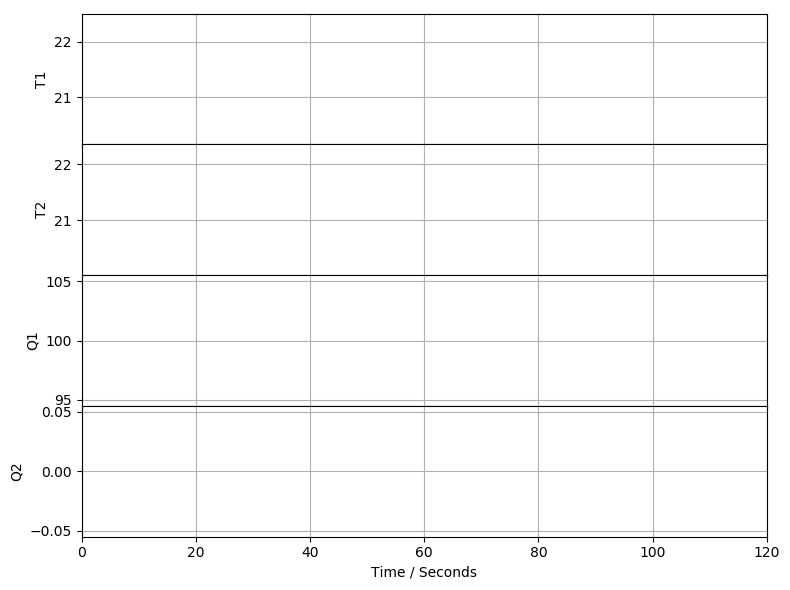

In [1]:
%gui asyncio

import asyncio
import tclab
from ipywidgets import FloatSlider

# define monotonic time function
time = asyncio.get_event_loop().time
tstart = time()
tstep = 2
tfinal = tstart + 100

SPslider = FloatSlider(min=40, max=80, step=0.5)

lab = tclab.setup(connected=False)
a = lab()
h = tclab.Historian(a.sources)
p = tclab.Plotter(h)
async def update():
    while time() < tfinal:
        t = time() - tstart
        PV = a.T1
        SP = SPslider.value
        MV = 100 if PV < SP else 0
        a.Q1(MV)
        p.update()
        await asyncio.sleep(tstep - (time() - tstart) % tstep)

task = asyncio.ensure_future(update())
SPslider


## Working with Tornado

This is an experiment to build a non-blocking event loop for TCLab.  The main idea is to implement the main event loop as a generator, then use Tornando's non-blocking timer to send periodic messages to the generator.

In [ ]:
%matplotlib inline
import tornado
import time
from tclab import setup, Historian, Plotter

SP = 40
Kp = 10

def update(lab):
    t = 0
    h = Historian(lab.sources)
    p = Plotter(h,120)
    while True:
        PV = lab.T1
        MV = Kp*(SP-PV)
        lab.U1 = MV
        p.update(t)
        yield
        t += 1

lab = setup(connected=True)
a = lab()
update_gen = update(a)
timer = tornado.ioloop.PeriodicCallback(lambda: next(update_gen), 1000)
timer.start()

In [ ]:
timer.stop()
a.close()

### Adding Widgets

`tclab.clock` is based on a generator, which maintains a single thread of execution. One consequence is that there is no interaction with Jupyter widgets.

In [ ]:
from ipywidgets import interactive
from IPython.display import display
from tclab import clock

Kp = interactive(lambda Kp: Kp, Kp = 12)
display(Kp)

for t in clock(10):
    print(t, Kp.result)

In [ ]:
import tornado
from ipywidgets import interactive
from IPython.display import display
from tclab import TCLab, Historian, Plotter

Kp = interactive(lambda Kp: Kp, Kp = (0,20))
SP = interactive(lambda SP: SP, SP = (25,55))
SP.layout.height = '500px'

def update(tperiod):
    t = 0
    with TCLab() as a:
        h = Historian(a.sources)
        p = Plotter(h)
        while t <= tperiod:
            yield
            p.update(t)
            display(Kp)
            display(SP)
            a.U1 = SP.result
            t += 1
        timer.stop()

update_gen = update(20)
timer = tornado.ioloop.PeriodicCallback(lambda: next(update_gen), 1000)
timer.start()

In [ ]:
from ipywidgets import interactive
from tclab import setup, clock, Historian, Plotter

def proportional(Kp):
    MV = 0
    while True:
        PV, SP = yield MV
        MV = Kp*(SP-PV)

def sim(Kp=1, SP=40):
    controller = proportional(Kp)
    controller.send(None)

    lab = setup(connected=False, speedup=20)
    with lab() as a:
        h = Historian(a.sources)
        p = Plotter(h,200)
        for t in clock(200):
            PV = a.T1
            MV = controller.send([PV,SP])
            a.U1 = MV
            h.update()
        p.update()   

interactive_plot = interactive(sim, Kp=(0,20,1), SP=(25,60,5), continuous_update=False);
output = interactive_plot.children[-1]
output.layout.height = '500px'
interactive_plot

In [ ]:
timer.stop()